<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Investigate any changes in AP after refactoring the makeKernel task</b> <br>
Contact author: Ian Sullivan<br>
Last verified to run: 02 February 2024<br>
LSST Science Piplines version: w_2024_07<br>
Run at USDF on the "2021 Diffim Sprint" HSC dataset


## Run details

Baseline run in comparison with pre-convolution

* Used weekly `w_2024_07` for both,
* rbClassifier_data from butler
* Run at USDF:  /sdf/home/s/sullii/project/tickets/DM-42814/submit/u/sullii/DM-42814/HSC/main/20240215T213237Z and /sdf/home/s/sullii/project/tickets/DM-42814/submit/u/sullii/DM-42814/HSC/ticket/20240215T215936Z



### 1. Main package imports

In [1]:
import os
import importlib
import pprint

In [2]:
import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

import numpy as np
import pandas as pd

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [4]:
import lsst.afw.display as afwDisplay
import lsst.geom

import lsst.daf.butler as dafButler
import lsst.pipe.base

In [5]:
!eups list analysis_ap

   LOCAL:/home/s/sullii/project/build/analysis_ap 	setup


In [6]:
from lsst.analysis.ap import apdb

In [7]:
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import nb_utils

In [8]:
from astropy.table import Table

In [9]:
importlib.reload(plac)

<module 'lsst.analysis.ap.legacyPlotUtils' from '/home/s/sullii/project/build/analysis_ap/python/lsst/analysis/ap/legacyPlotUtils.py'>

In [10]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

<module 'lsst.analysis.ap.legacyApdbUtils' from '/home/s/sullii/project/build/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py'>

### 2. Data access config
We are comparing multiple runs now, so we have to define where to find the data and the APDBs for each run.

#### Keys for default run.

In [11]:
repo = '/repo/main'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

dbType='postgres'
dbName='postgresql://rubin@usdf-prompt-processing-dev.slac.stanford.edu/lsst-devl'

dmnum = '42814'
collections = f'u/sullii/DM-{dmnum}/HSC/main'
schema = 'sullii_dm42814_hsc_appipe-main'

butler = dafButler.Butler(repo, collections=collections)

reader = apdb.ApdbPostgresQuery(schema, butler=butler, instrument=instrument)

In [12]:
len(reader._tables)

6

In [13]:
default_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [14]:
default_run['run_name'] = 'main'

#### This set is with the refactored makeKernelTask

In [15]:
repo = '/repo/main'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

dbType='postgres'
dbName='postgresql://rubin@usdf-prompt-processing-dev.slac.stanford.edu/lsst-devl'

dmnum = '42814'
collections = f'u/sullii/DM-{dmnum}/HSC/ticket'
schema = 'sullii_dm42814_hsc_appipe-ticket'

butler = dafButler.Butler(repo, collections=collections)

reader = apdb.ApdbPostgresQuery(schema, butler=butler, instrument=instrument)

In [16]:
len(reader._tables)

6

In [17]:
test_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [18]:
test_run['run_name'] = 'new_makeKernel'

## A. Analysis of Sources

### 3. Number of detections
Now loading the tables to compare among them

In [19]:
default_run['robjTable'] = default_run['reader'].load_objects()
default_run['rsrcTable'] = default_run['reader'].load_sources()

In [20]:
test_run['robjTable'] = test_run['reader'].load_objects()
test_run['rsrcTable'] = test_run['reader'].load_sources()

Look at how many objects and sources we picked right from the reader

In [21]:
n_objs = pd.DataFrame()

In [22]:
n_objs.loc[default_run['run_name'], 'n_rdiasrc'] = len(default_run['rsrcTable'])
n_objs.loc[default_run['run_name'], 'n_rdiaobj'] = len(default_run['robjTable'])

In [23]:
n_objs.loc[test_run['run_name'], 'n_rdiaobj'] = len(test_run['robjTable'])
n_objs.loc[test_run['run_name'], 'n_rdiasrc'] = len(test_run['rsrcTable'])

In [24]:
n_objs

n_rdiasrc  n_rdiaobj
main              16495.0    12472.0
new_makeKernel    16485.0    12287.0

In [25]:
test_table2 = test_run['reader'].load_sources()

In [26]:
object_columns = ['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean', 
                  'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
                  'validityEnd', 'flags']

In [27]:
source_columns = ['diaSourceId', 'diaObjectId', 'ra', 'dec', 'ccdVisitId', 'midpointMjdTai',
                  'apFlux', 'psfFlux', 'apFluxErr', 'psfFluxErr', 'scienceFlux', 'scienceFluxErr',
                  'snr', 'x', 'y', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'flags', 'reliability', 'band',
                  'visit', 'detector', 'instrument']

In [28]:
table1 = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()]

Inspect the columns of the object table

In [29]:
for c in table1.columns:
    print(c)

diaObjectId
validityStart
validityEnd
ra
raErr
dec
decErr
ra_dec_Cov
radecMjdTai
pmRa
pmRaErr
pmDec
pmDecErr
parallax
parallaxErr
pmRa_pmDec_Cov
pmRa_parallax_Cov
pmDec_parallax_Cov
pmParallaxLnL
pmParallaxChi2
pmParallaxNdata
u_psfFluxMean
u_psfFluxMeanErr
u_psfFluxSigma
u_psfFluxChi2
u_psfFluxNdata
u_fpFluxMean
u_fpFluxMeanErr
u_fpFluxSigma
g_psfFluxMean
g_psfFluxMeanErr
g_psfFluxSigma
g_psfFluxChi2
g_psfFluxNdata
g_fpFluxMean
g_fpFluxMeanErr
g_fpFluxSigma
r_psfFluxMean
r_psfFluxMeanErr
r_psfFluxSigma
r_psfFluxChi2
r_psfFluxNdata
r_fpFluxMean
r_fpFluxMeanErr
r_fpFluxSigma
i_psfFluxMean
i_psfFluxMeanErr
i_psfFluxSigma
i_psfFluxChi2
i_psfFluxNdata
i_fpFluxMean
i_fpFluxMeanErr
i_fpFluxSigma
z_psfFluxMean
z_psfFluxMeanErr
z_psfFluxSigma
z_psfFluxChi2
z_psfFluxNdata
z_fpFluxMean
z_fpFluxMeanErr
z_fpFluxSigma
y_psfFluxMean
y_psfFluxMeanErr
y_psfFluxSigma
y_psfFluxChi2
y_psfFluxNdata
y_fpFluxMean
y_fpFluxMeanErr
y_fpFluxSigma
u_lcPeriodic
g_lcPeriodic
r_lcPeriodic
i_lcPeriodic
z_lcPeriodic


Inspect the columns of the source table

In [30]:
table2 = default_run['rsrcTable']

In [31]:
for c in table2.columns:
    print(c)

diaSourceId
ccdVisitId
diaObjectId
ssObjectId
parentDiaSourceId
ssObjectReassocTime
midpointMjdTai
ra
raErr
dec
decErr
ra_dec_Cov
x
xErr
y
yErr
x_y_Cov
apFlux
apFluxErr
snr
psfFlux
psfFluxErr
psfRa
psfRaErr
psfDec
psfDecErr
psfFlux_psfRa_Cov
psfFlux_psfDec_Cov
psfRa_psfDec_Cov
psfLnL
psfChi2
psfNdata
trailFlux
trailFluxErr
trailRa
trailRaErr
trailDec
trailDecErr
trailLength
trailLengthErr
trailAngle
trailAngleErr
trailFlux_trailRa_Cov
trailFlux_trailDec_Cov
trailFlux_trailLength_Cov
trailFlux_trailAngle_Cov
trailRa_trailDec_Cov
trailRa_trailLength_Cov
trailRa_trailAngle_Cov
trailDec_trailLength_Cov
trailDec_trailAngle_Cov
trailLength_trailAngle_Cov
trailLnL
trailChi2
trailNdata
dipoleMeanFlux
dipoleMeanFluxErr
dipoleFluxDiff
dipoleFluxDiffErr
dipoleRa
dipoleRaErr
dipoleDec
dipoleDecErr
dipoleLength
dipoleLengthErr
dipoleAngle
dipoleAngleErr
dipoleMeanFlux_dipoleFluxDiff_Cov
dipoleMeanFlux_dipoleRa_Cov
dipoleMeanFlux_dipoleDec_Cov
dipoleMeanFlux_dipoleLength_Cov
dipoleMeanFlux_dipoleAng

In [32]:
ccdVisitIds = set(table2['ccdVisitId'])

In [33]:
ccdVisitIds

{2338049,
 2338050,
 2338057,
 2338058,
 2338065,
 2338066,
 2338449,
 2338450,
 2338457,
 2338458,
 2338465,
 2338466,
 2338849,
 2338850,
 2338857,
 2338858,
 2338865,
 2338866,
 2339249,
 2339250,
 2339257,
 2339258,
 2339265,
 2339266,
 2339649,
 2339650,
 2339657,
 2339658,
 2339665,
 2339666,
 2340049,
 2340050,
 2340057,
 2340058,
 2340065,
 2340066,
 2340449,
 2340450,
 2340457,
 2340458,
 2340465,
 2340466,
 2340849,
 2340850,
 2340857,
 2340858,
 2340865,
 2340866,
 2341249,
 2341250,
 2341257,
 2341258,
 2341265,
 2341266,
 2341649,
 2341650,
 2341657,
 2341658,
 2341665,
 2341666,
 2342049,
 2342050,
 2342057,
 2342058,
 2342065,
 2342066,
 5868049,
 5868050,
 5868057,
 5868058,
 5868065,
 5868066}

Now filter the objects which are not valid and pick the useful columns.

In [34]:
default_run['objTable'] = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()][object_columns]
default_run['srcTable'] = default_run['rsrcTable'][source_columns]

In [35]:
test_run['srcTable'] = test_run['rsrcTable'][source_columns]
test_run['objTable'] = test_run['robjTable'][test_run['robjTable'].validityEnd.isnull()][object_columns]

Check numbers once more

In [36]:
n_objs.loc[default_run['run_name'], 'n_diasrc'] = len(default_run['srcTable'])
n_objs.loc[default_run['run_name'], 'n_diaobj'] = len(default_run['objTable'])

In [37]:
n_objs.loc[test_run['run_name'], 'n_diasrc'] = len(test_run['srcTable'])
n_objs.loc[test_run['run_name'], 'n_diaobj'] = len(test_run['objTable'])

In [38]:
n_objs

n_rdiasrc  n_rdiaobj  n_diasrc  n_diaobj
main              16495.0    12472.0   16495.0   12472.0
new_makeKernel    16485.0    12287.0   16485.0   12287.0

Note that no objects were filtered out by the above check 

### 4. Flags 
Loading up the flag tables now

In [39]:
badFlagList = [
    'base_PixelFlags_flag_bad',
    'base_PixelFlags_flag_suspect',
    'base_PixelFlags_flag_saturatedCenter',
    'base_PixelFlags_flag_interpolated',
    'base_PixelFlags_flag_interpolatedCenter',
    'base_PixelFlags_flag_edge'
    ]

In [40]:
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

In [41]:
import functools
import operator

In [42]:
config = TransformDiaSourceCatalogConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')

In [43]:
def add_flag_tables(run_dict, badFlagList):
    """
    Unpack the flags and add the resulting tables to the run dictionary
    """
    run_dict['flagValues'] = unpacker.unpack(run_dict['srcTable']['flags'], 'flags')
    run_dict['flagTable'] = pd.DataFrame(run_dict['flagValues'], index=run_dict['srcTable'].index)

    run_dict['srcTableFlags'] = pd.merge(run_dict['srcTable'], run_dict['flagTable'], left_index=True, right_index=True)
    
    badFlags = [run_dict['srcTableFlags'][flag] for flag in badFlagList]
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter

    run_dict['goodSrc'] = run_dict['srcTableFlags'].loc[noFlagFilter]

    run_dict['goodObjIds'] = set(run_dict['srcTableFlags'].loc[noFlagFilter, 'diaObjectId'])

    run_dict['goodObj'] = run_dict['objTable'].loc[run_dict['objTable']['diaObjectId'].isin(run_dict['goodObjIds'])]
    
    return flagFilter, noFlagFilter

In [44]:
flagFilter, noFlagFilter = add_flag_tables(default_run, badFlagList)
flagFilter1, noFlagFilter1 = add_flag_tables(test_run, badFlagList)

In [45]:
n_objs.loc[default_run['run_name'], 'n_good_diaobj'] = len(default_run['goodObj'])
n_objs.loc[default_run['run_name'], 'n_good_diasrc'] = len(default_run['goodSrc'])

In [46]:
n_objs.loc[test_run['run_name'], 'n_good_diaobj'] = len(test_run['goodObj'])
n_objs.loc[test_run['run_name'], 'n_good_diasrc'] = len(test_run['goodSrc'])

In [47]:
n_objs

n_rdiasrc  n_rdiaobj  n_diasrc  n_diaobj  n_good_diaobj  \
main              16495.0    12472.0   16495.0   12472.0         4271.0   
new_makeKernel    16485.0    12287.0   16485.0   12287.0         4110.0   

                n_good_diasrc  
main                   6935.0  
new_makeKernel         6934.0

Text(0, 0.5, 'N')

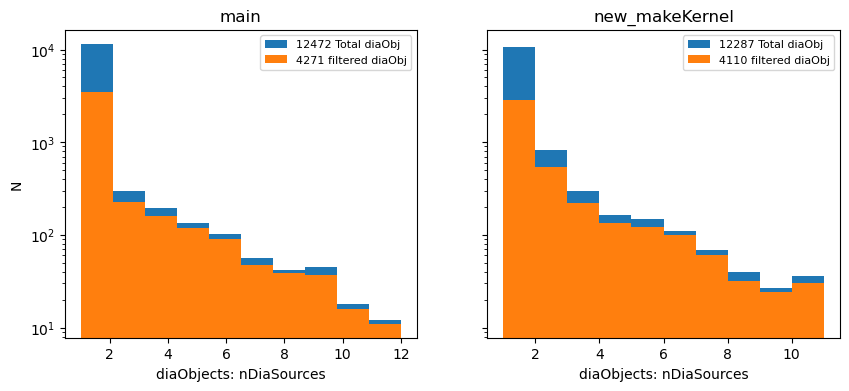

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i_run, run_dict in enumerate([default_run, test_run]):
    #plt.figure(figsize=(12, 8))
    ax = axes.flatten()[i_run]

    ax.hist(run_dict['objTable'].nDiaSources, log=True, label=f"{len(run_dict['objTable'])} Total diaObj")
    #plt.xlabel('diaObjects: nDiaSources')
    #plt.legend(loc='best')

    ax.hist(run_dict['goodObj'].nDiaSources, log=True, label=f"{len(run_dict['goodObj'])} filtered diaObj")
    ax.set_xlabel('diaObjects: nDiaSources')
    ax.legend(loc='best', fontsize=8)
    ax.set_title(run_dict['run_name'])
axes.flatten()[0].set_ylabel('N')

Very few objects with >1 diaSource are flagged with one of our canonical "bad" flags after the *CenterAll flag cut

## 4.1 Real-bogus reliability scores

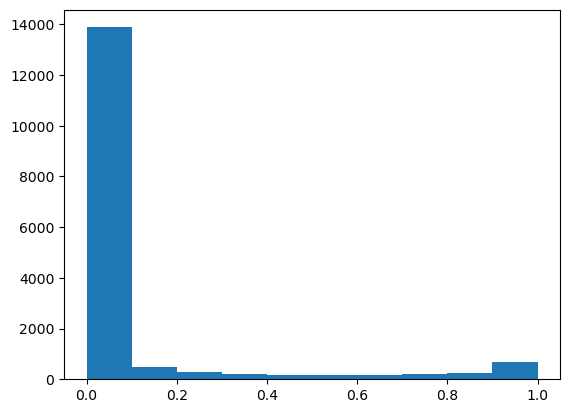

In [49]:
default_hist = plt.hist(default_run['srcTable']['reliability'])

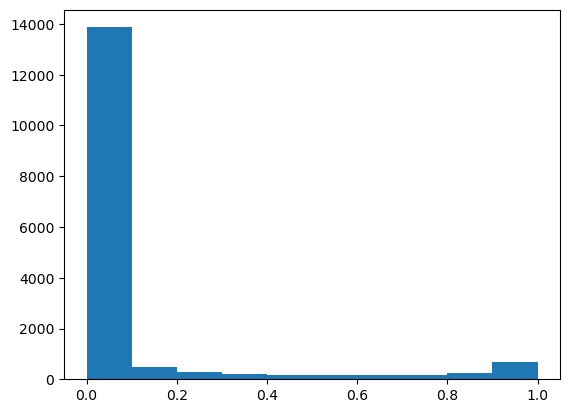

In [50]:
test_hist = plt.hist(test_run['srcTable']['reliability'])

In [51]:
reliability_table = pd.DataFrame()

In [52]:
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)

In [53]:
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[test_run['run_name']] = test_hist[0]
# reliability_table[test_run2['run_name']] = test_hist2[0]
# reliability_table[test_run3['run_name']] = test_hist3[0]

In [54]:
reliability_table

reliability     main  new_makeKernel
0          0.0  13886.0         13870.0
1          0.1    474.0           482.0
2          0.2    283.0           277.0
3          0.3    211.0           213.0
4          0.4    185.0           184.0
5          0.5    173.0           173.0
6          0.6    165.0           168.0
7          0.7    192.0           186.0
8          0.8    242.0           244.0
9          0.9    684.0           688.0

In [55]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(test_hist[0][5:]))
# print(np.sum(test_hist2[0][5:]))
# print(np.sum(test_hist3[0][5:]))

0.500000000000029
1456.0
1459.0


### Repeat with only good sources

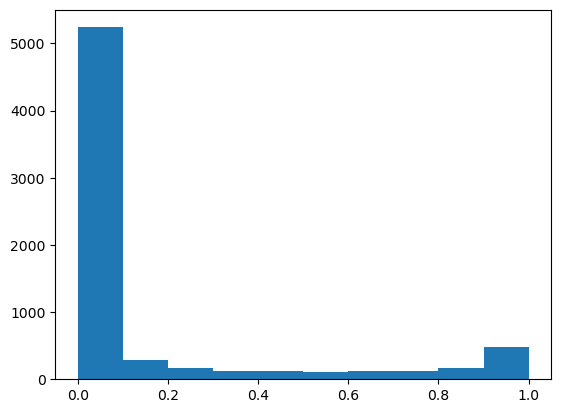

In [56]:
default_hist = plt.hist(default_run['goodSrc']['reliability'])

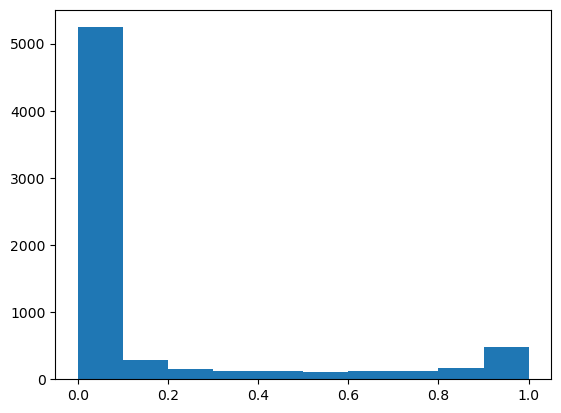

In [57]:
test_hist = plt.hist(test_run['goodSrc']['reliability'])

In [58]:
reliability_table = pd.DataFrame()

In [59]:
reliability_table = pd.DataFrame()
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[test_run['run_name']] = test_hist[0]
# reliability_table[test_run2['run_name']] = test_hist2[0]

In [60]:
reliability_table

reliability    main  new_makeKernel
0          0.0  5239.0          5244.0
1          0.1   282.0           282.0
2          0.2   163.0           158.0
3          0.3   128.0           128.0
4          0.4   116.0           116.0
5          0.5   109.0           110.0
6          0.6   120.0           124.0
7          0.7   130.0           122.0
8          0.8   167.0           167.0
9          0.9   481.0           483.0

In [61]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(test_hist[0][5:]))
# print(np.sum(test_hist2[0][5:]))

0.5000000000165539
1007.0
1006.0


There is much less of a difference seen between the objects that are flagged as "good". 

## 5. Sky plots on sources

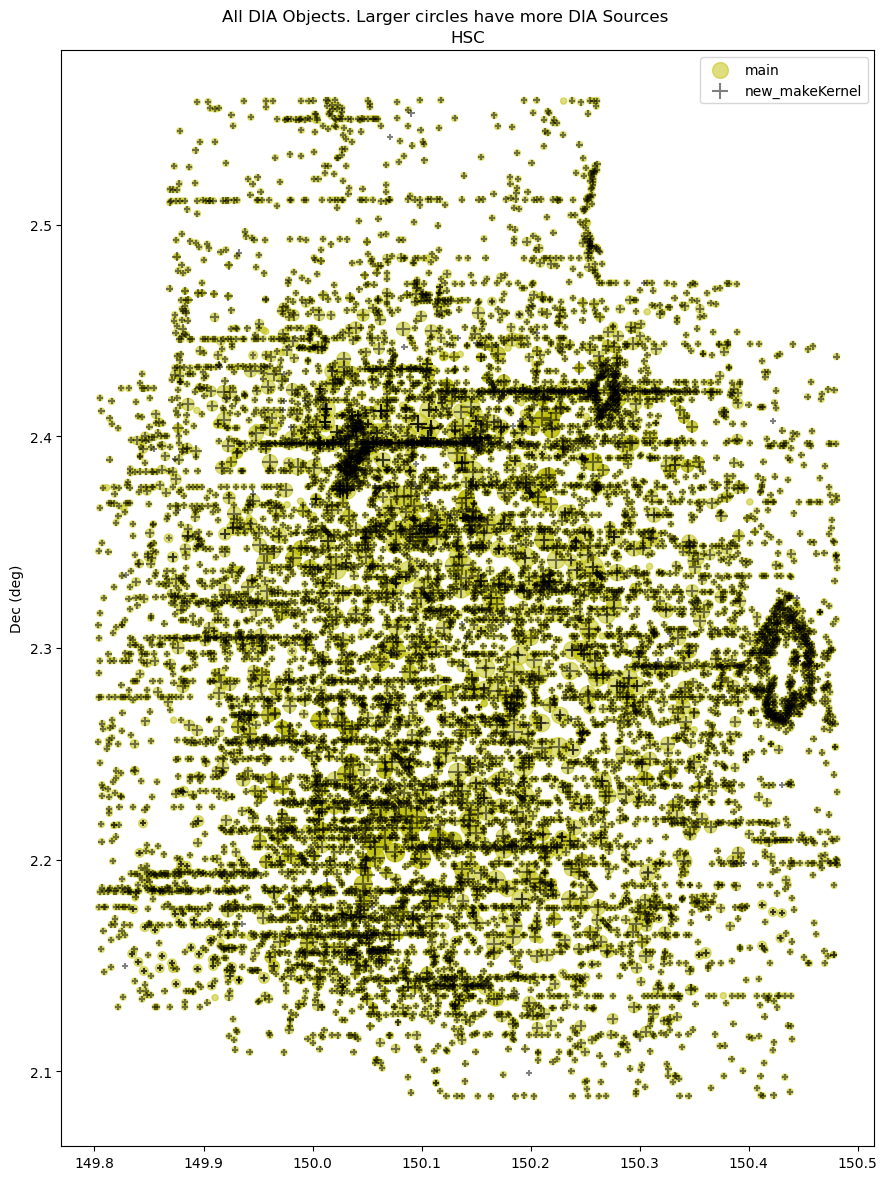

In [62]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, test_run]):

#     xlim = [149.7, 149.5]
#     ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodFilter = (run_dict['objTable']['nDiaSources'] > nSrc)
#     goodFilter = run_dict[]
    
#     axG = axs[i_run]
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('HSC')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']

    ax.scatter(run_dict['objTable'].loc[goodFilter, 'ra'],
               run_dict['objTable'].loc[goodFilter, 'dec'],
               s=run_dict['objTable'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

In [63]:
table_test = run_dict['goodObj']

In [64]:
table_test.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean',
       'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

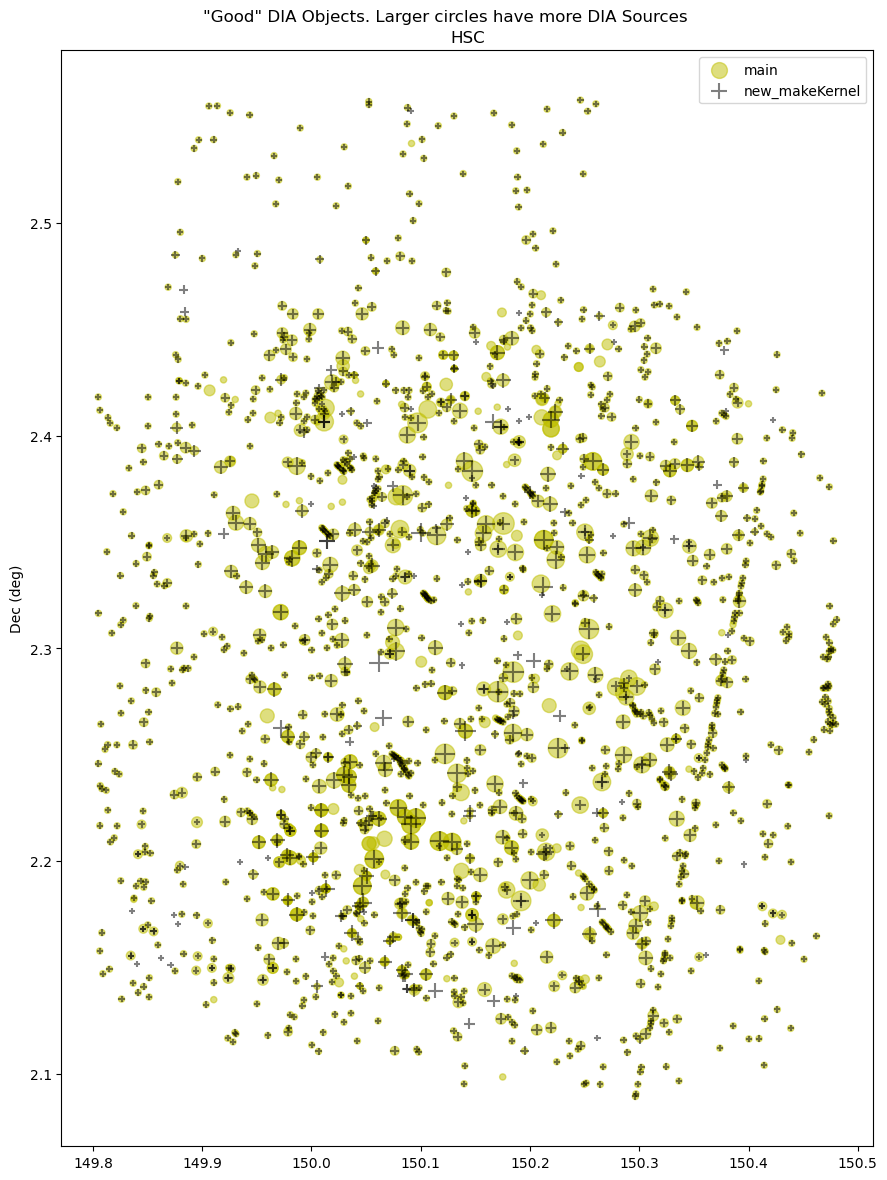

In [65]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, test_run]):

#     xlim = [149.7, 149.5]
#     ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodFilter = (run_dict['goodObj']['nDiaSources'] > nSrc) &\
                 (run_dict['goodObj']['g_psfFluxMean'] > 0)
#     goodFilter = run_dict[]
    
#     axG = axs[i_run]
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('HSC')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']

    ax.scatter(run_dict['goodObj'].loc[goodFilter, 'ra'],
               run_dict['goodObj'].loc[goodFilter, 'dec'],
               s=run_dict['goodObj'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

## 4.2 Comparison of diaSources between runs

In [66]:
objectTable = default_run['goodObj']
objectTable1 = test_run['goodObj']
# objectTable2 = test_run2['goodObj']
# objectTable3 = test_run3['goodObj']

In [67]:
objectTable.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean',
       'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

In [68]:
obj_default, obj_test, obj_match = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                            default_run['reader'], test_run['reader'],
                                                            match_radius=0.1, display_cutouts=False,
                                                            bad_flag_list=badFlagList,
                                                            make_cutouts=False)

6675 matched sources; 260 unique to set 1; 270 unique to set 2.


In [69]:
highObs_default = obj_default.diaSourceId[obj_default['reliability'] > 0.1]

In [70]:
highObs_test = obj_test.diaSourceId[obj_test['reliability'] > 0.1]

In [71]:
len(highObs_default)

75

In [72]:
len(highObs_test)

74

In [73]:
!pwd

/home/s/sullii/notebooks/ap_pipe-notebooks/notebooks


In [76]:
obj_default, obj_test, obj_match = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                            default_run['reader'], test_run['reader'],
                                                            match_radius=0.1, display_cutouts=False,
                                                            bad_flag_list=badFlagList,
                                                            cutout_path1='../../../project/tickets/DM-42814/cutouts/good/main',
                                                            cutout_path2='../../../project/tickets/DM-42814/cutouts/good/ticket',
                                                            make_cutouts=True)

6675 matched sources; 260 unique to set 1; 270 unique to set 2.


In [74]:
all_default, all_test, all_match = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                            default_run['reader'], test_run['reader'],
                                                            match_radius=0.1, display_cutouts=False,
                                                            bad_flag_list=[],
                                                            make_cutouts=False)

16064 matched sources; 431 unique to set 1; 471 unique to set 2.


In [75]:
all_default, all_test, all_match = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                            default_run['reader'], test_run['reader'],
                                                            match_radius=0.1, display_cutouts=False,
                                                            bad_flag_list=[],
                                                            cutout_path1='../../../project/tickets/DM-42814/cutouts/all/main',
                                                            cutout_path2='../../../project/tickets/DM-42814/cutouts/all/ticket',
                                                            make_cutouts=True)

16064 matched sources; 431 unique to set 1; 471 unique to set 2.


## 6. Cutouts

### 7. Flag frequency analysis

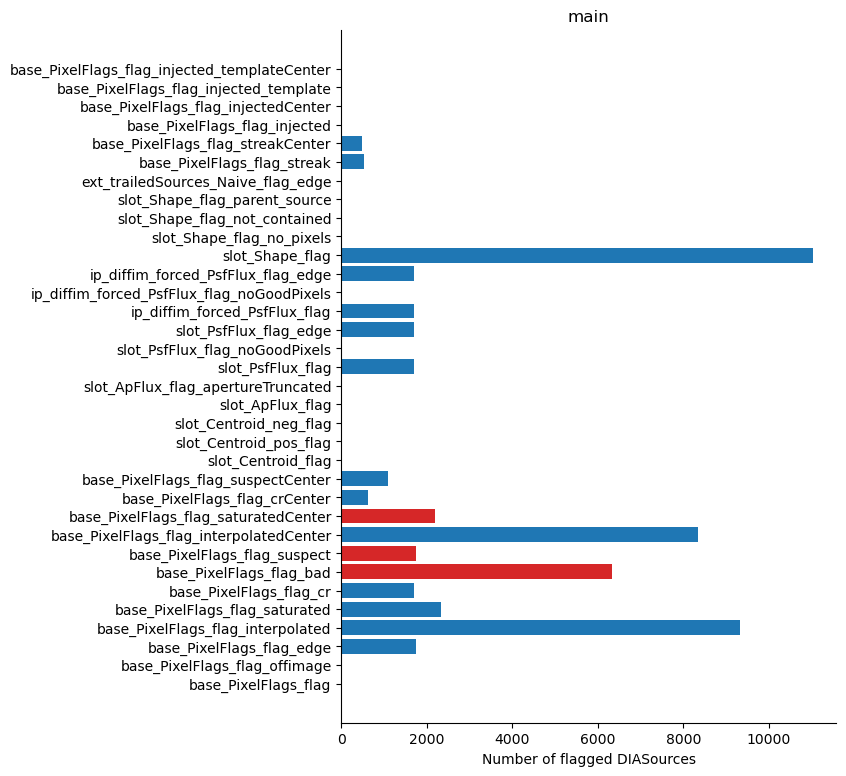

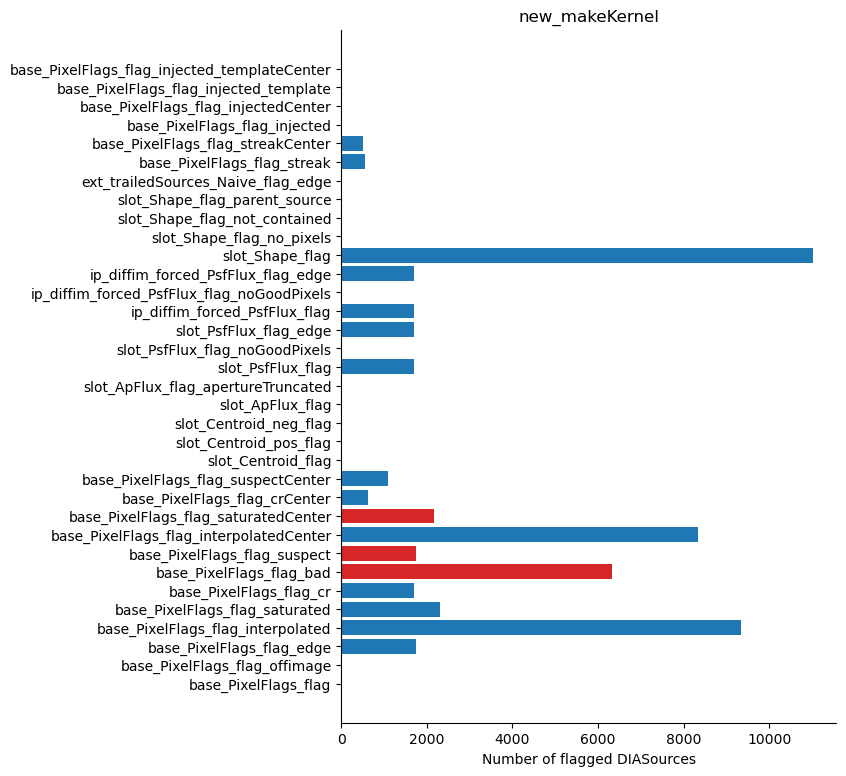

In [75]:
for arun in [default_run, test_run]:
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    
    plac.plotFlagHist(srcTable, title=f'{arun["run_name"]}')

### 8. diaSource reliability score

Not really part of this ticket, but since we have all the sources available let's compare diaSource reliability scores from real-bogus between runs.

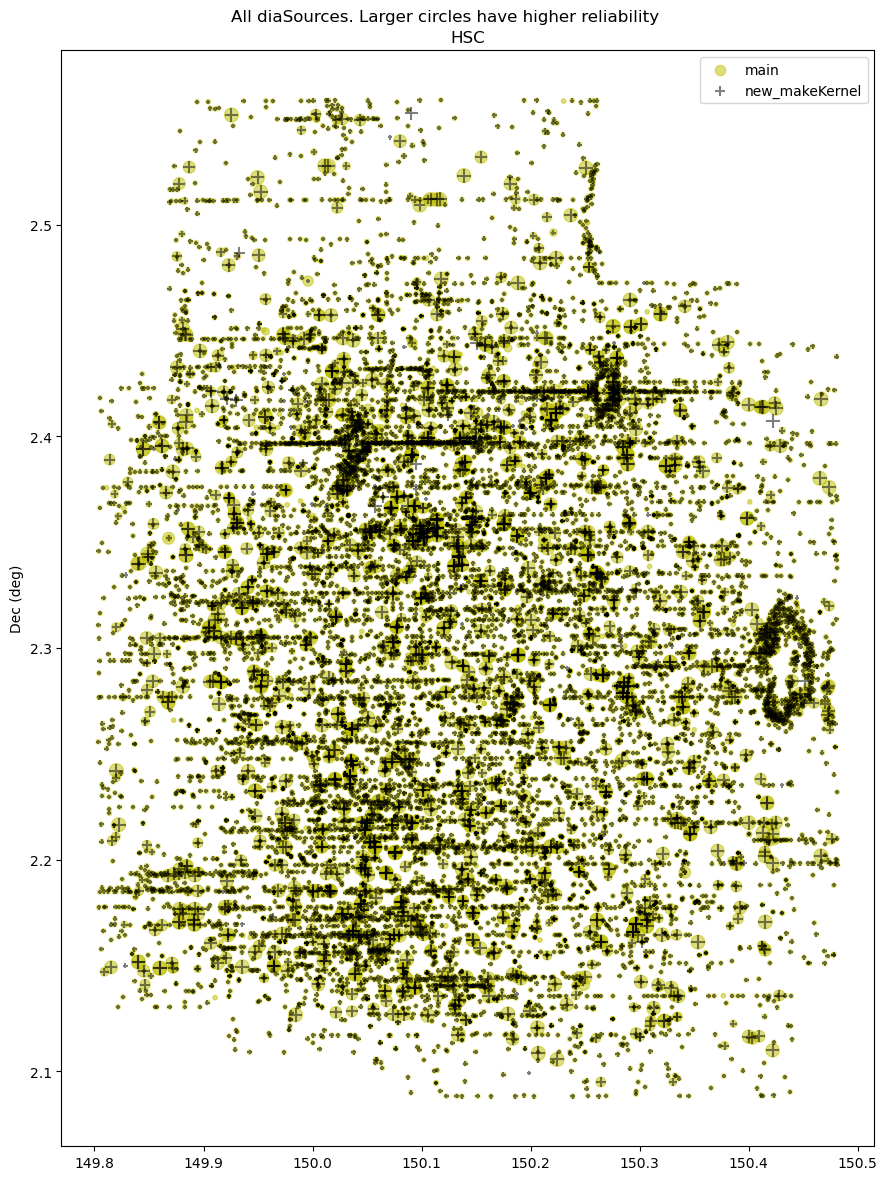

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([default_run, test_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('HSC')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['srcTable']['reliability']*100
    sizes = [max([s, 10]) for s in sizes]

    ax.scatter(run_dict['srcTable']['ra'],
               run_dict['srcTable']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

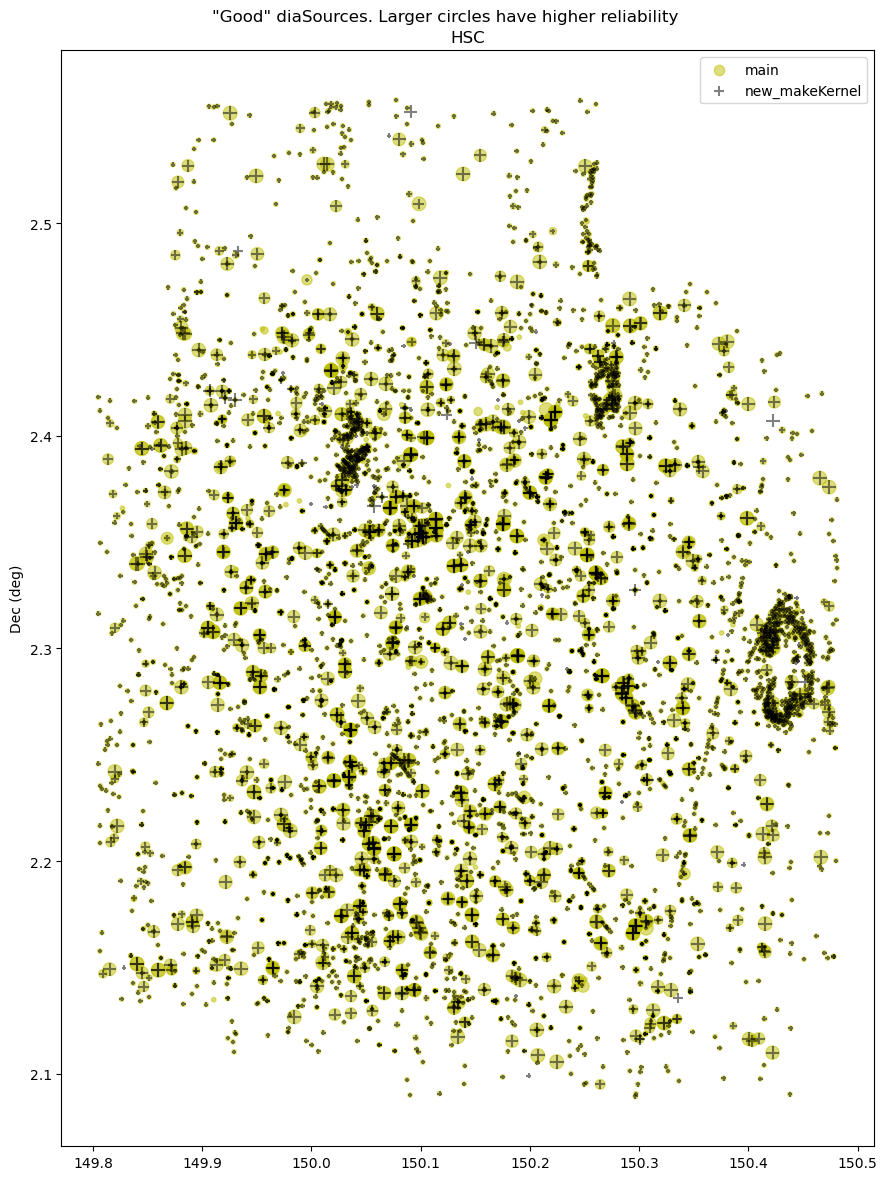

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([default_run, test_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('HSC')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['goodSrc']['reliability']*100
    sizes = [max([s, 10]) for s in sizes]

    ax.scatter(run_dict['goodSrc']['ra'],
               run_dict['goodSrc']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()